In [1]:
using Revise

In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [3]:
using PotentialFlow

In [4]:
using CairoMakie

# This is useful for the contour plots around bodies
using Plots
pyplot()

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1664


Plots.PyPlotBackend()

In [5]:
using LaTeXStrings

In [6]:
using Distributions
using Random
using LinearAlgebra

In [7]:
using GaussianMixtures

In [7]:
#Random.seed!(1234)


### Bodies

In [13]:
#a1 = 0.25; b1 = 0.0; ccoeff = ComplexF64[0.5(a1+b1),0,0.5(a1-b1)]
#b = Bodies.ConformalBody(ccoeff,ComplexF64(0.0),-π/4)
a1 = 0.5; b1 = 0.1; ccoeff = ComplexF64[0.5(a1+b1),0,0.5(a1-b1)]
b = Bodies.ConformalBody(ccoeff,ComplexF64(0.0),0.0)
#motion = RigidBodyMotion(-1.0-0.3im,0.0)
motion = RigidBodyMotion(-1.0,0.0)

Bodies.enforce_no_flow_through!(b,motion,Element[],0.0)

#w = SchwarzChristoffel.naca4(0.0,0.0,0.12)
#p = Bodies.Polygon(w)
#b = Bodies.ConformalBody(p)

# for plotting purposes
bz = [b.zs; b.zs[1]]
bpts = hcat(real(bz),imag(bz));

### Evaluation grids and sensors

#### Evaluation grid

In [14]:
rmax = 5.0   # largest radial coordinate (smallest is 1)
ϵ = 0.00001 # small offset from the surface of the unit circle
nth = 200   # number of circumferential points
dth = 2π/nth
θ = range(0,2π,length=nth+1)
dr = dth
r = [1+ϵ]
while maximum(r) < rmax
    push!(r,r[end]+dr)
    dr = r[end]*dth
end
ζg = r'.*exp.(im*θ)
zg = conftransform(ζg,b);
xg = real(zg)
yg = imag(zg)

nothing

In [169]:
# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle. For force sensors, set this to three, just to specify number.
rsens = 1.0
Nsens = 11
θsens = range(0,2π,length=Nsens+1)
sens = rsens*exp.(im*θsens[1:end-1]); # circle plane
sens_z = physical_space_sensors(sens,b);

#=
# For a thick plate
θsens_top = range(0.1,π-0.1,length=Nsens+1)
sens_top = rsens*exp.(im*θsens_top); # circle plane
sens_top_z = physical_space_sensors(sens_top,b);
sens_bot = ComplexF64[]
θsens_bot = range(π+0.1,2π-0.1,length=Nsens+1)
sens_bot = rsens*exp.(im*θsens_bot);
sens_bot_z = physical_space_sensors(sens_bot,b);
sens = vcat(sens_top,sens_bot)
sens_z = physical_space_sensors(sens,b);
=#

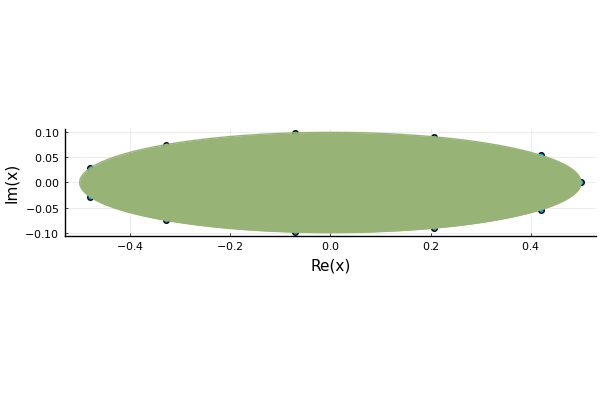

In [170]:
Plots.scatter(sens_z)
Plots.plot!(b)

### Truth

In [171]:
using JLD

In [172]:
data = load("psurf_t025_Re200.jld")
#data = load("psurf_plate_t080_Re500.jld")

#data = load("psurf_circle_t100_Re500.jld")

zdata = data["x"] .+ im*data["y"];
pdata = data["p"];
ζdata = inverse_conftransform(zdata,b);
θdata = imag(log.(ζdata./abs.(ζdata)));

pdata .-= mean(pdata);

In [173]:
idxlist = Int[]
maxerr = 0.0
for sensj in sens_z
    err,idx = findmin(abs.(zdata .- sensj))
    maxerr = max(maxerr,err)
    push!(idxlist,idx)
end

#=
zdata_top = view(zdata,1:88)
for sensj in sens_top_z
    err,idx = findmin(abs.(zdata_top .- sensj))
    maxerr = max(maxerr,err)
    push!(idxlist,idx)
end

imin_bot = 93
zdata_bot = view(zdata,imin_bot:183)
for sensj in sens_bot_z
    err,idx = findmin(abs.(zdata_bot .- sensj))
    maxerr = max(maxerr,err)
    push!(idxlist,idx+imin_bot-1)
end
=#

ystar = pdata[idxlist];

In [174]:
length(ystar)

11

In [175]:
idxlist

11-element Vector{Int64}:
   1
   8
  23
  43
  61
  72
  78
  89
 107
 127
 142

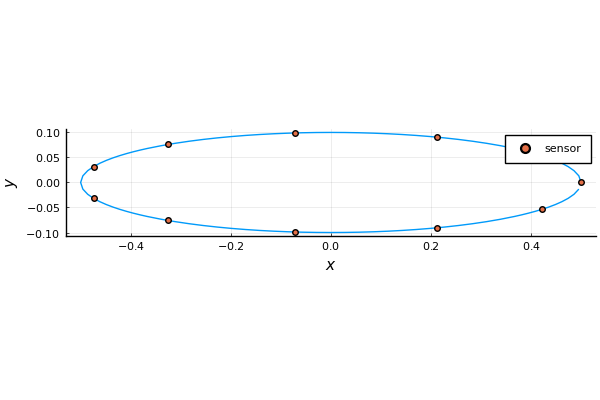

In [176]:
Plots.plot(zdata,ratio=1,label="")
Plots.scatter!(zdata[idxlist],label="sensor",xlabel=L"x",ylabel=L"y")
#Plots.scatter!(sens_top_z)
#savefig("basicdata-circle-11sensor.pdf")

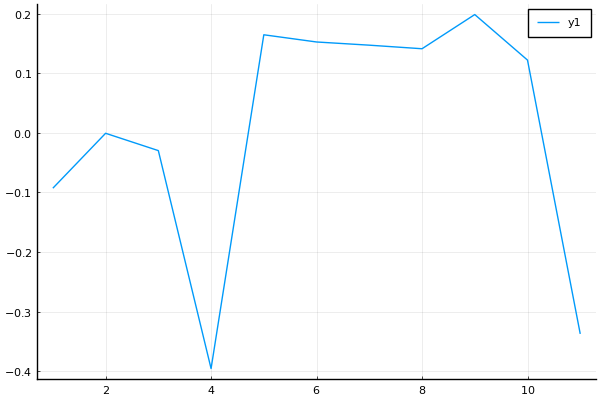

In [177]:
Plots.plot(ystar)

In [161]:
Nv_cluster = 2
Nv_per_cluster = 1
#z0 = complex(0.0)
#Γ0 = 1.0
δ_true = 0.1

# create random clusters
rr = (1.2,2.0)
θr = (0.0,2π)
Γr = (-2,0)
σx = 0.03
σΓ = 0.03
Nv_true = Nv_cluster*Nv_per_cluster 

ζv, Γv = createclusters(Nv_cluster,Nv_per_cluster,rr,θr,Γr,σx,σΓ;body=b,each_cluster_radius=1.5*σx)
zv = Elements.conftransform(ζv,b)

truez = zv

# create specified cluster(s)
#zv = [-0.25+im*0.25, 0.25-im*0.25]
#Γv = [1.0,-1.0]
#Nv_true = Nv_cluster*Nv_per_cluster 
#ζv = Elements.inverse_conftransform(zv,b)

config_data_true = VortexConfig(Nv_true, δ_true, body=b)
#Γv .= 0.0

vort = Vortex.Blob.(ζv,Γv,δ_true)
vort_z = Elements.conftransform(vort,b);

x_true = lagrange_to_state_reordered(vort,config_data_true);

In [162]:
[sum(Γv[(j-1)*Nv_per_cluster+1:j*Nv_per_cluster]) for j in 1:Nv_cluster]

2-element Vector{Float64}:
 -1.5160093602415365
 -0.21897265888126288

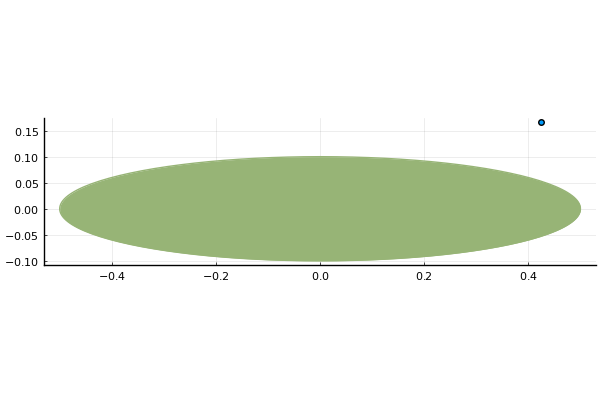

In [19]:
#f = Figure(; resolution = (400, 400))
#ax = Axis(f[1,1]; limits=(-1,1,-1,1),title = "Scatter plot", xlabel = L"x",aspect=DataAspect())
#CairoMakie.scatter!(ax,real.(zv),imag.(zv))
#CairoMakie.poly!(ax,bpts,color=:gray)
Plots.scatter(real.(zv),imag.(zv))
Plots.plot!(b)

In [20]:
ptrue_field = analytical_pressure(ζg,vort,config_data_true);

In [198]:
#xmin, xmax = -1, 1
#l = range(-3,1,length=31)
#cl = (-3,1)
#contour(xg,yg,ptrue_field,ratio=1,levels=l,color=:RdBu,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
#plot!(b)

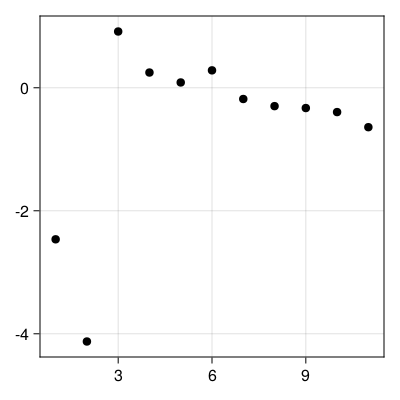

In [21]:
obs_true = PressureObservations(sens,config_data_true);
#obs_true = ForceObservations(config_data_true);
ystar = observations(x_true,obs_true);
f = CairoMakie.plot(ystar; figure = (; resolution = (400, 400)))

## Single vortex estimation

In [210]:
Nv_one = 2
δ = 0.1

config_1vortex_data = VortexConfig(Nv_one, δ,body=b)

# prior
# force
#ϵmeas = 3e-3 #1e-3 #5e-4 #1e-3
#ϵr = 5e-4 #1e-4 #1e-4
#ϵrθ = 5e-3 #5e-3 #1e-3 #3e-4
#ϵΓ = 5e-3 #1e-3 #1e-4

# pressure
ϵmeas = 5e-3 #5e-4 #1e-3
ϵr = 1e-3 #1e-4
ϵrθ = 3e-3 #3e-4
ϵΓ = 1e-3 #1e-4

# ranges to confine the prior mean to
rr = (1.2,1.8) # (1.2,1.4)
θr = (0,2π)
Γr = (-2.0,2.0)

obs = PressureObservations(sens,config_1vortex_data);
#obs = ForceObservations(config_1vortex_data);

### MCMC approach

In [211]:
function sort_state_by_strength(x,config::VortexConfig)
    zv, Γv = state_to_positions_and_strengths(x,config)
    #Γv = sum(Γv) < 0 ? -Γv : Γv
    #idx = sortperm(Γv)
    idx = 1:length(Γv)
    positions_and_strengths_to_state(zv[idx],Γv[idx],config)
end

sort_state_by_strength (generic function with 1 method)

In [212]:
Σϵ = Diagonal(ϵmeas^2*ones(length(sens)));

In [334]:
log(0.001)

-6.907755278982137

In [518]:
Ntrial = 10000
propvarX = 0.001^2
propvarY = 0.003^2
propvarΓ = 0.001^2
propvar = Diagonal(vcat(propvarX*ones(Nv_one),propvarY*ones(Nv_one),propvarΓ*ones(Nv_one)));

In [519]:
β = 10.0.^(range(0,-3,length=5))
#β = 2.0.^(range(0,-3,length=5))
nchain = length(β)
propvars = [propvar for i = 1:nchain]./β
xseeds = [generate_random_state(rr,θr,Γr,obs.config) for n = 1:nchain]
#xseeds = [x_data[j][:,end] for j = 1:nchain]
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,x -> LowRankVortex.loglikelihood(x,ystar,Σϵ,obs),propvars;burnin=1,β=β);

In [512]:
logp_data[1]

10000-element Vector{Float64}:
 -5385.407338698426
 -5385.407338698426
 -5385.407338698426
 -5385.407338698426
 -5385.407338698426
 -5383.779576172314
 -5383.779576172314
 -5383.779576172314
 -5383.053566569893
 -5383.053566569893
 -5381.60741594768
 -5381.60741594768
 -5381.60741594768
     ⋮
 -4035.6222052039034
 -4035.2720612413473
 -4035.2720612413473
 -4035.2720612413473
 -4035.2720612413473
 -4035.2720612413473
 -4035.598441440333
 -4035.598441440333
 -4038.1481366434455
 -4038.1481366434455
 -4034.387722042043
 -4034.387722042043

In [513]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.2708
 0.1122
 0.0071
 0.0291
 0.3495

In [514]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.0
 0.0
 0.026537997587454766
 0.002331002331002331

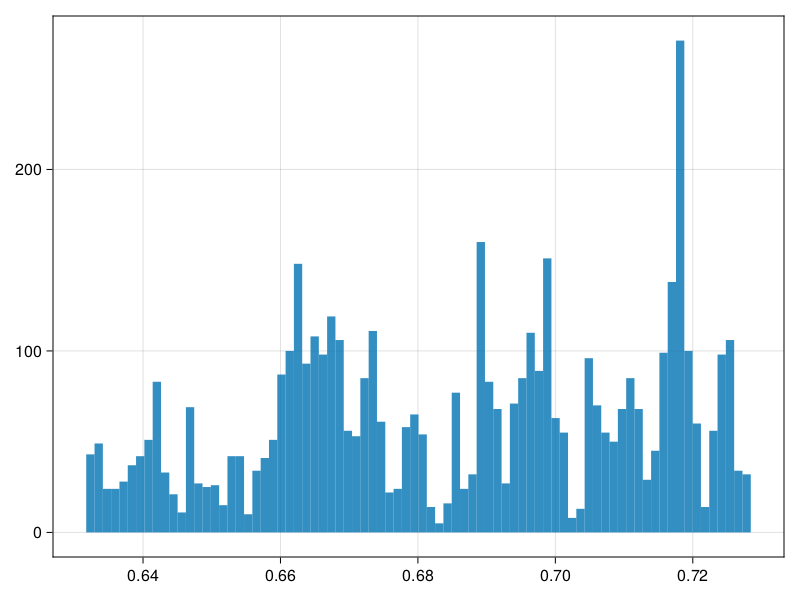

In [515]:
hist(x_data[1][1,Ntrial÷2:Ntrial],bins=80)
current_figure()

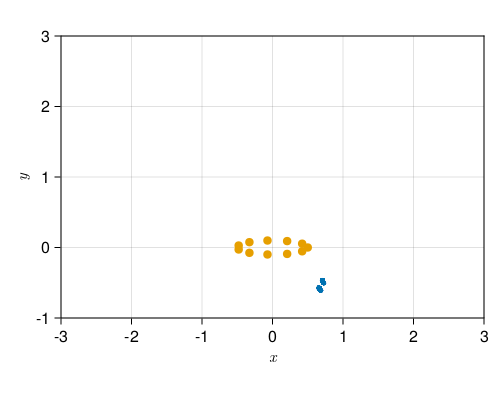

In [516]:
f = Figure(;resolution=(500,400))

ax = Axis(f[1,1];limits=(-3,3,-1,3),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")

for n in 1:1
    x_array = states_to_vortex_states(x_data[n][:,Ntrial÷2:1:Ntrial],obs.config);
    CairoMakie.scatter!(ax,x_array[1,:],x_array[2,:],markersize=5)
end

#CairoMakie.scatter!(ax,xmean_array[1,:],xmean_array[2,:],marker=:rect,markersize=15,color=:transparent,strokewidth=1)
#CairoMakie.scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=15,color=:transparent,strokewidth=1)
CairoMakie.scatter!(ax,real(sens_z),imag(sens_z))
#save("samples-2vortex-2truth-5sensor-case0.pdf",f)
f

#=
CairoMakie.scatter(xtop_array[1,:],xtop_array[2,:],markersize=5,color=:red,axis=(;limits=(-1,1,-1,1)))
CairoMakie.scatter!(xbest_array[1,:],xbest_array[2,:],markersize=5,color=:blue)
#CairoMakie.scatter(xmean_array[1,:],xmean_array[2,:],markersize=5)
#CairoMakie.scatter!(real(truez),imag(truez),marker=:circle,markersize=15,color=:transparent,strokewidth=1)
CairoMakie.scatter!(real(sens_z),imag(sens_z))
CairoMakie.current_figure()
=#

In [517]:
x_fulldata_trans = x_data[1][:,Ntrial÷2:Ntrial]
x_fulldata = zero(transpose(x_fulldata_trans))
x_fulldata .= transpose(x_fulldata_trans);

In [490]:
gm = GMM(1,x_fulldata,kind=:diag,method=:kmeans,nIter=30);

In [491]:
transpose(means(gm)[weights(gm).>0.3,:])

6×1 transpose(::Matrix{Float64}) with eltype Float64:
 -2.9824253973903163
 -1.5563242919904006
  1.8417263382551898
 -0.6217321500389419
  0.6876094857501746
  0.4781741082967036

In [492]:
x_true

6-element Vector{Float64}:
 -0.46195554054889587
 -1.1243367107194298
  2.5213182089230686
  2.8705034405252063
 -1.5160093602415365
 -0.21897265888126288

In [493]:
xbest = vec(transpose(means(gm)[weights(gm).>0.3,:]))

6-element reshape(transpose(::Matrix{Float64}), 6) with eltype Float64:
 -2.9824253973903163
 -1.5563242919904006
  1.8417263382551898
 -0.6217321500389419
  0.6876094857501746
  0.4781741082967036

### EnKF approach

In [161]:
sol_collection = vortexinference(ystar,rr,θr,Γr,ϵmeas,ϵr,ϵrθ,ϵΓ,obs;lowrank=true,linear_flag=false,maxiter=20,numsample=15,inflate=true,errtol=0.5);

In [1]:
goodones, minyerr, sol_yerr  = classify_by_data_mismatch(sol_collection,obs,kcluster=5);
sol_goodones = sol_collection[goodones]

density_flag = false
if length(sol_goodones) > 1 && density_flag
    bestones = classify_by_density(sol_goodones,obs);
else
    bestones = deepcopy(sol_goodones)
end
sol_bestones = sol_goodones[bestones]

xtoplist = collect_estimated_states(sol_bestones,obs.config)
xtop_array = states_to_vortex_states(xtoplist,obs.config);

bestsol = sol_bestones[1]
xbest = mean(bestsol[end].X)
xbest_array = state_to_vortex_states(xbest,obs.config)

LoadError: UndefVarError: classify_by_data_mismatch not defined

In [163]:
minyerr

137.67757615507026

In [164]:
sol_yerr[goodones]

2-element Vector{Float64}:
 131.1333783521083
 144.22177395803223

In [165]:
bestsol = sol_bestones[1]
xbest = mean(bestsol[end].X)
xbest_array = state_to_vortex_states(xbest,obs.config)

3×2 Matrix{Float64}:
  0.523528  -0.381898
  0.815161  -0.935818
 -2.35008    2.32822

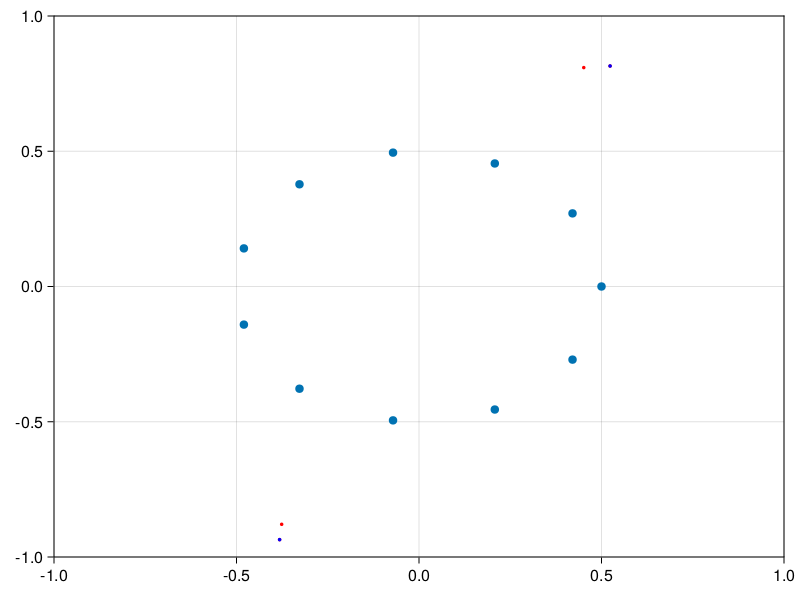

In [166]:
CairoMakie.scatter(xtop_array[1,:],xtop_array[2,:],markersize=5,color=:red,axis=(;limits=(-1,1,-1,1)))
CairoMakie.scatter!(xbest_array[1,:],xbest_array[2,:],markersize=5,color=:blue)
#CairoMakie.scatter(xmean_array[1,:],xmean_array[2,:],markersize=5)
#CairoMakie.scatter!(real(truez),imag(truez),marker=:circle,markersize=15,color=:transparent,strokewidth=1)
CairoMakie.scatter!(real(sens_z),imag(sens_z))
CairoMakie.current_figure()

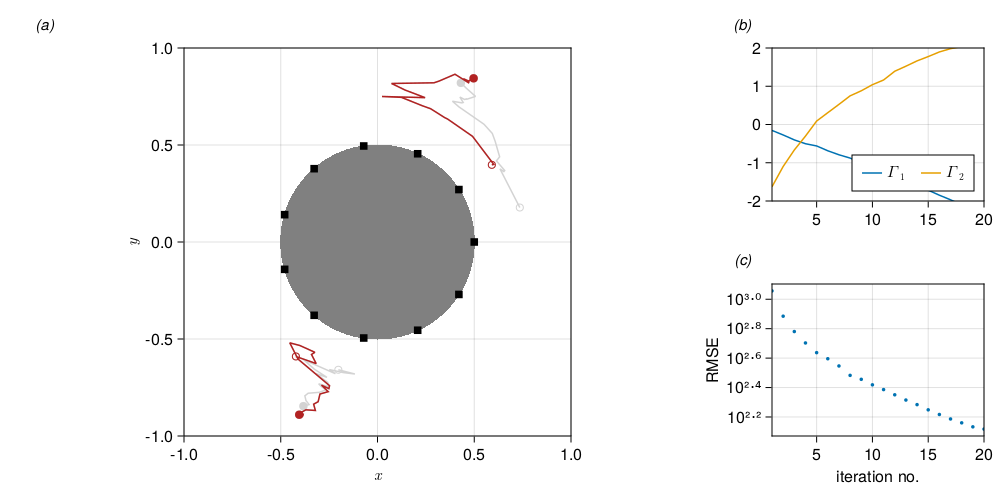

In [168]:
fulltraj = true
plotbadones = false

sampsol = bestsol #sol_collection[goodones[2]]

ftraj = Figure(;resolution=(1000,500))
ga = ftraj[1,1] = GridLayout()
gb = ftraj[1,2] = GridLayout()

axtraj = Axis(ga[1,1];limits=(-1,1,-1,1),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
with_theme(LowRankVortex.trajectory_theme()) do    
    
    if fulltraj
        for this_solhist in sol_bestones
            trajectory!(axtraj,this_solhist,obs,color=:lightgray)
        end
        if plotbadones
            for this_solhist in sol_collection[badones]
                trajectory!(axtraj,this_solhist,obs,color=LowRankVortex.color_palette[3])
            end
        end
        trajectory!(axtraj,bestsol,obs,color=LowRankVortex.color_palette[1])
    else
        xpost = vec(xgood[1,:])
        ypost = vec(xgood[2,:])
        Γpost = vec(xgood[3,:])
        scatter!(axtraj,xpost,ypost,markersize=5,color=LowRankVortex.color_palette[1])
        xbestpost = xbest_array[1,1:obs.config.Nv]
        ybestpost = xbest_array[2,1:obs.config.Nv]
        Γbestpost = xbest_array[3,1:obs.config.Nv]
        scatter!(axtraj,xbestpost,ybestpost,markersize=20,color=LowRankVortex.color_palette[2])
        xcenter = goodstate[1,:]
        ycenter = goodstate[2,:]
        Γcenter = goodstate[3,:]
        #scatter!(axtraj,xcenter,ycenter,markersize=20,color=LowRankVortex.color_palette[4])
    end
    poly!(axtraj,bpts,color=:gray)
    CairoMakie.scatter!(axtraj,real(sens_z),imag(sens_z),marker=:rect,color=:black)
    #CairoMakie.scatter!(axtraj,real(truez),imag(truez),marker=:star5,markersize=15,color=:black)
end
#save("soltraj-1vortex-3sensor.pdf",ftraj)   

# circulation plot
gb1 = gb[1,1] = GridLayout()
gb2 = gb[2,1] = GridLayout()
axa = Axis(gb1[1,1];limits=(1,length(sampsol),-2.0,2.0))

#=
# plot the true circulations
ztrue, Γtrue = state_to_positions_and_strengths(x_true,config_data_true)
for j in 1:config_data_true.Nv
    #lines!(axa,real(ztrue[j])*ones(length(sampsol)),linestyle=:dash)
    #lines!(axa,imag(ztrue[j])*ones(length(sampsol)),linestyle=:dash)
    lines!(axa,Γtrue[j]*ones(length(sampsol)),linestyle=:dash,color=:black)
end
=#
for j in 1:obs.config.Nv
    #lines!(axa,map(x -> mean(x.Xf)[2j-1],sampsol),markersize=2,label=L"x")
    #lines!(axa,map(x -> mean(x.Xf)[2j],sampsol),markersize=2,label=L"y")
    lines!(axa,map(x -> mean(x.Xf)[2obs.config.Nv+j],sampsol),markersize=2,label=L"\Gamma_{%$j}")
end
axislegend(axa,orientation=:horizontal,position=:rb)

yerrhist = map(x -> x.yerr,sampsol)
axb = Axis(gb2[1,1];yscale=log10,xlabel="iteration no.",ylabel="RMSE")
linkxaxes!(axb,axa)
pl = CairoMakie.scatter!(axb,yerrhist,markersize=5)
CairoMakie.xlims!(axb,(1,length(yerrhist)))
#save("convergence-1vortex-3sensor.pdf",f)

colsize!(ftraj.layout, 2, Auto(0.35))

for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb1, gb2])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 20, 15, 0),
        halign = :right)
end
#save("trajectories-2vortex-24sensor-plate-t040-Re500.pdf",ftraj)

ftraj

In [89]:
#xmin, xmax = -1, 1
#xg = range(xmin,xmax,length=201)
#yg = range(xmin,xmax,length=201)
#zg = xg .+ im*yg';

In [494]:
vort_post = state_to_lagrange_reordered(xbest,obs.config;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = observations(xbest,obs)
p_post_field = analytical_pressure(ζg,vort_post,obs.config);

### Comparing inviscid to viscous

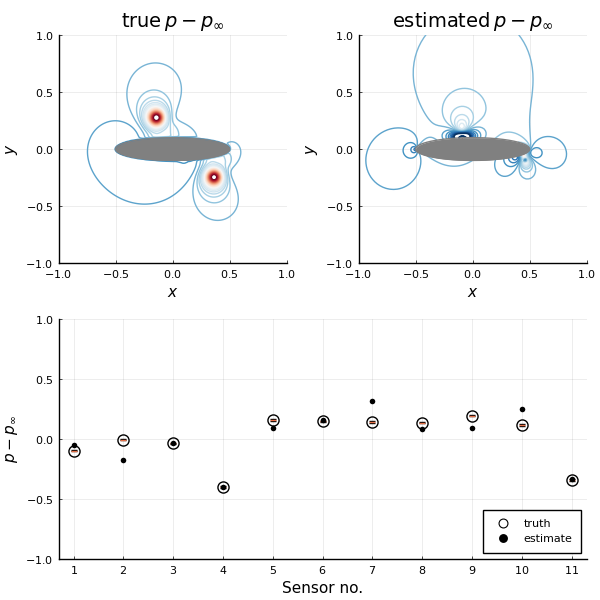

In [495]:
l = @layout [[a b]
                c{0.5h}]

cl = (-3,1)
lev = range(-3,1,length=31)
pleft = Plots.contour(data["xp"],data["yp"],data["pfield"]',xlims=(-1,1),ylims=(-1,1),clim=cl,levels=lev,color = :RdBu,xlabel=L"x",ylabel=L"y",linewidths=1,colors=:RdBu,legend=false,title=L"\mathrm{true}\, p - p_\infty")
Plots.plot!(pleft,b,fillcolor=:gray,linecolor=:gray)
pcenter = Plots.scatter(ystar.-mean(ystar),marker=:circle,markersize=8,markeralpha=0,markerstrokealpha=1,xticks=1:length(sens),label="truth",ylims=(-1,1),xlabel="Sensor no.",ylabel=L"p-p_\infty",legend=:bottomright)
Plots.scatter!(pcenter,ystar.-mean(ystar),marker=:hline,yerror=ϵmeas,label="")
Plots.scatter!(pcenter,y_post.-mean(y_post),marker=:circ,markersize=4,markerstrokealpha=0,markercolor=:black,label="estimate")
pright = Plots.contour(xg,yg,p_post_field,xlims=(-1,1),ylims=(-1,1),clim=cl,levels=lev,color = :RdBu,xlabel=L"x",ylabel=L"y",linewidths=1,colors=:RdBu,legend=false,title=L"\mathrm{estimated}\, p - p_\infty")
Plots.plot!(pright,b,fillcolor=:gray,linecolor=:gray)
Plots.plot(pleft,pright,pcenter,layout=l,size=(600,600))
#savefig("pressure-2vortex-24sensor-plate-t040-Re500.pdf")

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


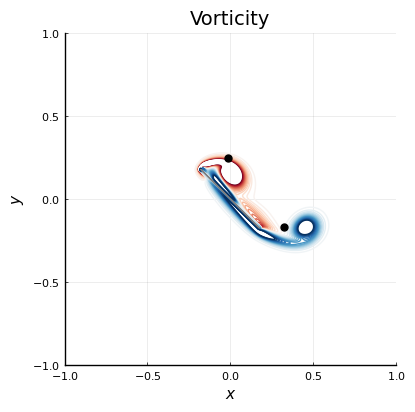

"/Users/jeff/JuliaProjects/LowRankVortex/stationary/vorticity-2vortex-24sensor-plate-t040-Re500.pdf"

In [113]:
pleft = Plots.contour(data["xw"],data["yw"],data["vort"]',xlims=(-1,1),ylims=(-1,1),clim=(-20,20),levels=range(-20,20,length=30),color = :RdBu,xlabel=L"x",ylabel=L"y",linewidths=1,colors=:RdBu,colorbar=false,title="Vorticity")
Plots.scatter!(pleft,xbest_array[1,:],xbest_array[2,:],markersize=5,markercolor=:black,label="Estimated vortex",legend=true)
Plots.plot!(pleft,b,fillcolor=:gray,linecolor=:gray)
savefig("vorticity-2vortex-24sensor-plate-t040-Re500.pdf")

In [480]:
xtop_array[3,:]

2-element Vector{Float64}:
 -0.808432775060907
  0.5327907219906142

### Comparing inviscid to inviscid

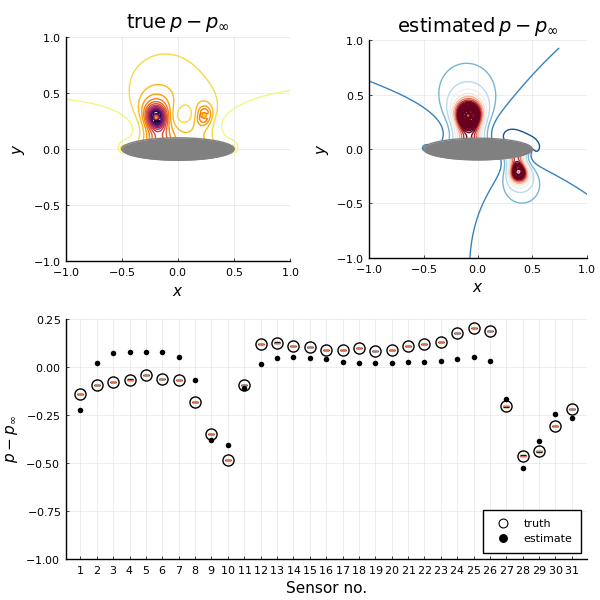

In [407]:
l = @layout [[a b]
                c{0.5h}]

pleft = Plots.contour(xg,yg,ptrue_field,xlims=(-1,1),ylims=(-1,1),xlabel=L"x",ylabel=L"y",linewidths=1,colors=:RdBu,legend=false,title=L"\mathrm{true}\, p - p_\infty")
Plots.plot!(pleft,b,fillcolor=:gray,linecolor=:gray)
pcenter = Plots.scatter(ystar,marker=:circle,markersize=8,markeralpha=0,markerstrokealpha=1,xticks=1:length(sens),label="truth",ylims=(-1,0.25),xlabel="Sensor no.",ylabel=L"p-p_\infty",legend=:bottomright)
Plots.scatter!(pcenter,ystar,marker=:hline,yerror=ϵmeas,label="")
Plots.scatter!(pcenter,y_post,marker=:circ,markersize=4,markerstrokealpha=0,markercolor=:black,label="estimate")
pright = Plots.contour(xg,yg,p_post_field,xlims=(-1,1),ylims=(-1,1),clim=(-0.5,0.1),levels=31,color = :RdBu,xlabel=L"x",ylabel=L"y",linewidths=1,colors=:RdBu,legend=false,title=L"\mathrm{estimated}\, p - p_\infty")
Plots.plot!(pright,b,fillcolor=:gray,linecolor=:gray)
Plots.plot(pleft,pright,pcenter,layout=l,size=(600,600))
#savefig("pressure-2truth-2vortex-21sensor-ellipse-case2.pdf")

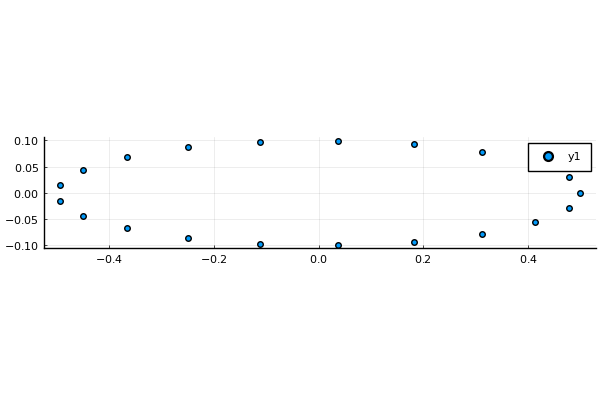

In [363]:
Plots.scatter(real(sens_z),imag(sens_z),ratio=1)

LoadError: UndefVarError: normals not defined

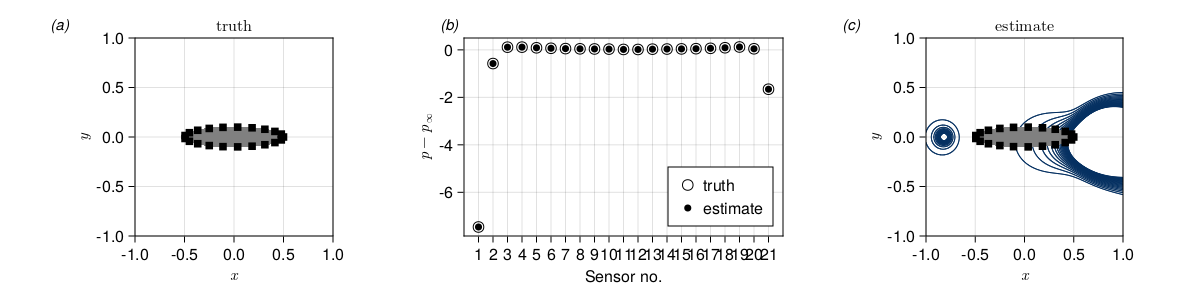

In [76]:
l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-1,1,-1,1),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-1,1,-1,1),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)

#contour!(axleft,xg,yg,ptrue_field,levels=l,colormap=:RdBu)
poly!(axleft,bpts,color=:gray)
scatter!(axleft,real(sens_z),imag(sens_z),marker=:rect,color=:black)
contour!(axright,xg,yg,p_post_field,levels=l,colormap=:RdBu)
poly!(axright,bpts,color=:gray)
scatter!(axright,real(sens_z),imag(sens_z),marker=:rect,color=:black)


# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
scatter!(axcenter,ystar,markersize=15,color=:transparent,strokewidth=1,label="truth")
scatter!(axcenter,y_post,markersize=10,color=:black,label="estimate")
axislegend(axcenter,position=:rb)

for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("pressure-2vortex-2truth-11sensor-cluster3.pdf",f)

f

In [48]:
jdex = length(solhist)
vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_1vortex_data;isblob=true);
y_post = observations(mean(solhist[jdex].X),obs)
p_post_field = analytical_pressure(ζg,vort_post,config_1vortex_data)
plot(y_post,label="posterior")
plot!(ystar,label="truth")

LoadError: UndefVarError: solhist not defined

In [356]:
sqrt(cov(whiten(solhist[end].X,solhist[end].Σx)))

3×3 Matrix{Float64}:
  5.22915    -0.0613872  -0.277362
 -0.0613872   2.13321     0.947801
 -0.277362    0.947801    0.888854

In [317]:
solhist[end].ΣX̆Y̆*inv(solhist[end].ΣY̆)

3×3 Matrix{Float64}:
 -0.252287   -0.0609007  -0.0547016
  0.0724701   1.04503     0.240351
  0.643291   -0.19549    -1.39388

In [318]:
solhist[end].Y̆

Ensemble with 50 members of 3-dimensional data
3×50 Matrix{Float64}:
 -1.51494  -2.63906   -1.72791    0.954357  …   4.20784   -5.00761  -3.46178
  1.74956   2.35354   -0.0760774  1.37888      -1.25031    1.47786  -0.854643
 -1.23998  -0.680758  -1.08489    0.39185      -0.670384  -1.76902   0.463585

In [319]:
solhist[end].V

3×3 Matrix{Float64}:
 0.0274564   0.0272205   0.999252
 0.303125   -0.952788    0.0176258
 0.952555    0.302415   -0.0344114

In [320]:
Bodies.enforce_no_flow_through!(b,RigidBodyMotion(0.0,0.0),vort,0.0)
imp_true = Elements.impulse((b,vort))
circ_true = Elements.circulation(vort)
Bodies.enforce_no_flow_through!(b,RigidBodyMotion(0.0,0.0),vort_post,0.0)
imp_post = Elements.impulse((b,vort_post))
circ_post = Elements.circulation(vort_post)
circ_true, circ_post,imp_true, imp_post

(0.5617662122690078, 0.6368647846292642, 0.7322959187744517 + 0.25958730380191725im, 0.8215685937636139 + 0.24811428700097832im)

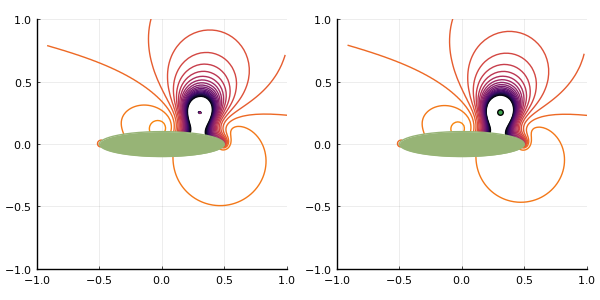

In [49]:
l = range(-2,1,length=31)
cl = (-2,1)
pl1 = contour(xg,yg,ptrue_field,ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
plot!(pl1,b)
#scatter!(pl1,real.(zv),imag.(zv))
#scatter!(pl1,real.(sens_z),imag.(sens_z))
#plot!(x,y,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
pl2 = contour(xg,yg,p_post_field,ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
plot!(pl2,b)
scatter!(pl2,real.(Elements.position(vort_post_z)),imag.(Elements.position(vort_post_z)))
#scatter!(pl2,real.(sens_z),imag.(sens_z))
p1 = plot(pl1,pl2,size=(600,300))
#savefig("flatplate-zerovortex-withmotion-pfield-force.pdf")

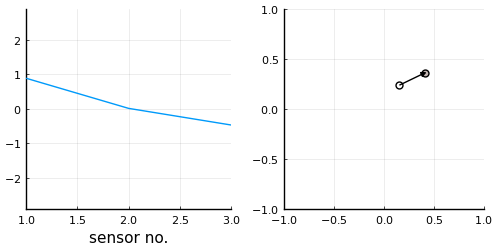

In [268]:
showmode(20,3,solhist,config_1vortex_data,size=(500,250),xlim=(-1,1),ylim=(-1,1))

### Multiple vortices

In [111]:
Nv = 2
δ = 0.01 #0.01
ϵmeas = 1e-3 #1e-3
ϵX = 5e-3 #5e-3
ϵΓ = 5e-3 #5e-2 #5e-3
Ne = 50

#config_data = VortexConfig(Nv, δ, walltype=LowRankVortex.FlatWall)
config_data = VortexConfig(Nv, δ, body=b)


Σx = Diagonal(vcat(ϵX^2*ones(Nv),ϵX^2*ones(Nv),ϵΓ^2*ones(Nv)));
Σϵ = Diagonal(ϵmeas^2*ones(length(sens)))

# ranges to confine the prior mean to
rr = (1.2,1.4)
θr = (0,2π)
Γr = (0.0,2.0)

obs = ForceObservations(config_data);

In [112]:
sol_collection = vortexinference(ystar,rr,θr,Γr,ϵmeas,ϵr,ϵrθ,ϵΓ,obs;linear_flag=false,maxiter=150,numsample=5,inflate=true);

In [113]:
collection_err = map(x -> x[end].yerr,sol_collection)

5-element Vector{Float64}:
 0.4515771911653171
 0.7118809658463368
 0.9342641692292879
 0.9930854952762306
 0.9740958958444813

In [114]:
minerr, sampnum = findmin(collection_err)
solhist = sol_collection[sampnum];

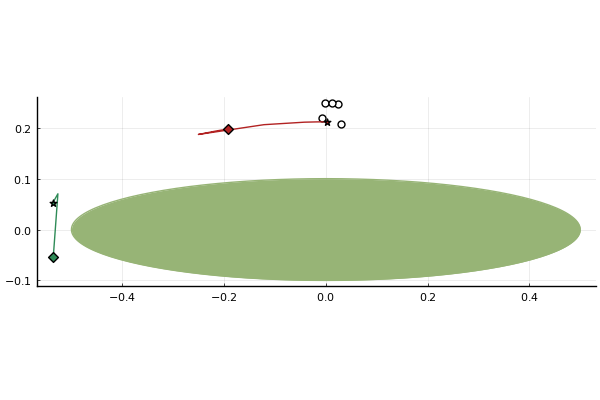

In [115]:
pl = filtertrajectory(solhist,obs,vort_z,legend=false,markersize=5)
#pl = filtertrajectory(solhist,sens_z,x_true,markersize=5)
#savefig("3cluster-traj-3vortex-11linesensors.pdf")

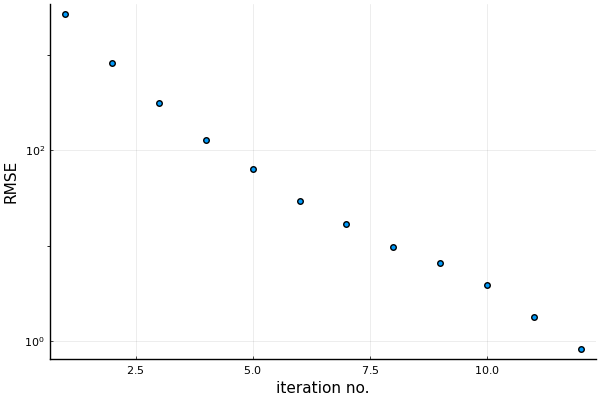

In [88]:
yerrhist = map(x -> x.yerr,solhist)
scatter(yerrhist,yscale=:log10,xlabel="iteration no.",ylabel="RMSE",legend=false)

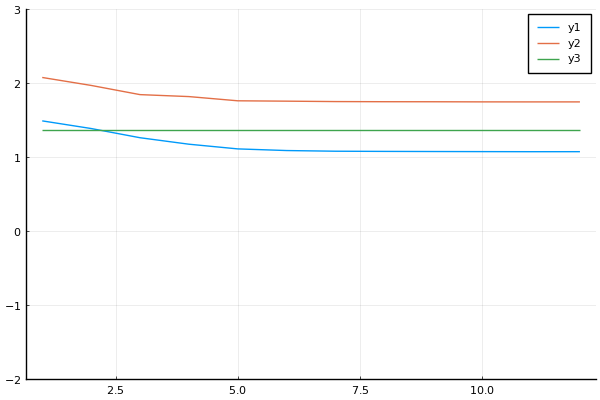

In [91]:
plot()
for i in 1:Nv
    plot!(map(x -> mean(x.X)[2Nv+i],solhist),ylim=(-2,3))
end
plot!(sum(x_true[2Nv_true+1:3Nv_true])*ones(length(solhist)))

┌ Info: Saved animation to 
│   fn = /Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/lW9ll/src/animation.jl:137


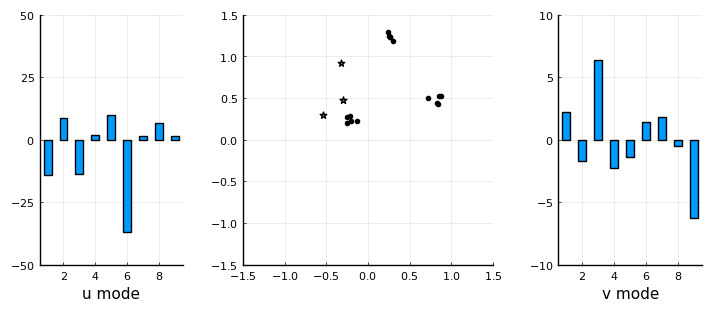

Plots.AnimatedGif("/Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif")
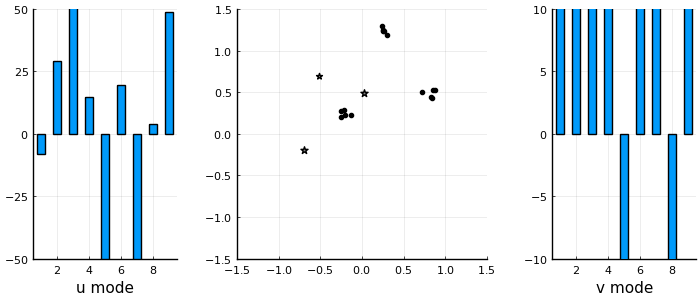

In [293]:
@gif for j in 1:length(solhist)
    filterstepplot(j,solhist,x_true,xlim=(-1.5,1.5),ylim=(-1.5,1.5),size=(700,300),arrows_on=false,ubarscale=0.1,vbarscale=0.1)
end every 1

In [3735]:
Λxmaxhist = map(x -> maximum(x.Λx),solhist);
Λxminhist = map(x -> minimum(x.Λx),solhist);

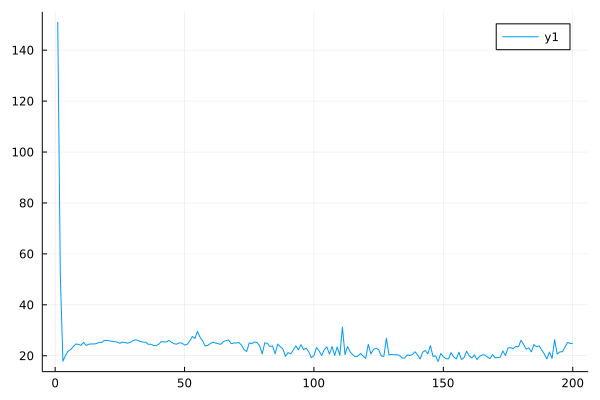

In [3736]:
plot(sqrt.(Λxmaxhist./Λxminhist))

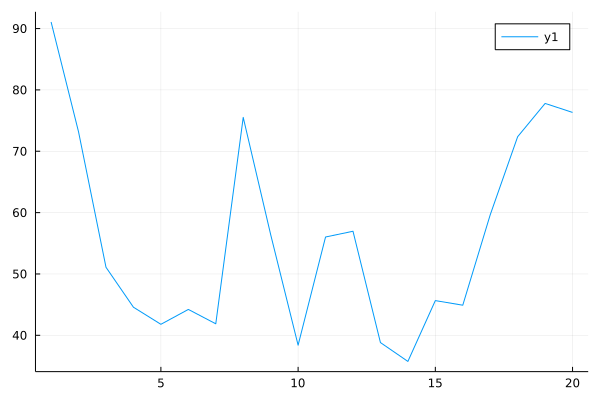

In [2868]:
Λymaxhist = map(x -> maximum(x.Λy),solhist);
Λyminhist = map(x -> minimum(x.Λy[11]),solhist);
plot(sqrt.(Λymaxhist./Λyminhist))

In [1032]:
# For plotting modes of sensors on a grid
#=
jdex = 1
V = solhist[jdex].V
U = solhist[jdex].U;
mode = 5
zv_j = Elements.position(state_to_lagrange_reordered(mean(solhist[jdex].Xf),config_data;isblob=true));

Ugrid = reshape(U[:,mode],(81,81))

maxv = 5/length(sens)
plot(xsens,ysens,Ugrid',ratio=1,legend=false,levels=range(-maxv,maxv,length=31),clim=(-maxv,maxv),xlim=(-2.5,2.5),ylim=(-2.5,2.5))
scatter!(real.(zv_j),imag.(zv_j),markersize=5,markershape=:circle,markercolor=:black)
plot(xsens[9:73],Ugrid[9:73,25])
=#

In [717]:
jdex = length(solhist)
Λ = Diagonal(sqrt.(solhist[jdex].Λx))
Λ

9×9 Diagonal{Float64, Vector{Float64}}:
 5.36884   ⋅        ⋅        ⋅        …   ⋅         ⋅         ⋅ 
  ⋅       1.83982   ⋅        ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅       1.05287   ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅        ⋅       0.861659      ⋅         ⋅         ⋅ 
  ⋅        ⋅        ⋅        ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅        ⋅        ⋅        …   ⋅         ⋅         ⋅ 
  ⋅        ⋅        ⋅        ⋅           0.344979   ⋅         ⋅ 
  ⋅        ⋅        ⋅        ⋅            ⋅        0.327551   ⋅ 
  ⋅        ⋅        ⋅        ⋅            ⋅         ⋅        0.208736

In [722]:
inv(Λ^2+I)

9×9 Diagonal{Float64, Vector{Float64}}:
 0.0335295   ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅         0.228053   ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅          ⋅        0.474265   ⋅            ⋅         ⋅         ⋅ 
  ⋅          ⋅         ⋅        0.573903      ⋅         ⋅         ⋅ 
  ⋅          ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅          ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅          ⋅         ⋅         ⋅           0.893647   ⋅         ⋅ 
  ⋅          ⋅         ⋅         ⋅            ⋅        0.903106   ⋅ 
  ⋅          ⋅         ⋅         ⋅            ⋅         ⋅        0.958249

In [721]:
inv(solhist[jdex].ΣY̆)

9×9 Matrix{Float64}:
  0.0420401    -0.0010616  -0.000171404  …   0.0141555   0.00326242
 -0.0010616     0.14375     0.014616        -0.0250818  -0.0114332
 -0.000171404   0.014616    0.347951        -0.0344829  -0.0172207
 -0.00351684   -0.012441    0.00144629      -0.114739   -0.0345511
 -0.00377549   -0.0143413  -0.019293        -0.0729741  -0.0194355
  0.0182224     0.0124882   0.0490452    …  -0.108692   -0.147509
 -0.00896326    0.0229053   0.00709967      -0.0447372  -0.027746
  0.0141555    -0.0250818  -0.0344829        1.5497      0.0710118
  0.00326242   -0.0114332  -0.0172207        0.0710118   1.10896

In [718]:
Λ*inv(Λ^2+I)

9×9 Diagonal{Float64, Vector{Float64}}:
 0.180015   ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅        0.419577   ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅         ⋅        0.499337   ⋅            ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅        0.494508      ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅           0.308289   ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅        0.295814   ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅        0.200021

In [723]:
K̆ = solhist[jdex].ΣX̆Y̆*inv(solhist[jdex].ΣY̆)

9×9 Matrix{Float64}:
 -0.156281    0.0162501  -0.0784775  -0.0142543   …  -0.0398326   -0.00759577
  0.0839904  -0.36931     0.159266    0.0708149       0.0604963    0.0258808
 -0.0105751   0.175896   -0.0245319   0.664425       -0.186462    -0.0414131
 -0.249184   -0.192956    0.395542    0.180979       -0.0911877   -0.026134
 -0.0453958  -0.118877   -0.176088   -0.136194        0.00612355  -0.0588428
  0.183985    0.0154491   0.175801    0.849524    …  -0.0826283    0.010563
  0.179823   -0.207566   -0.296979   -0.132168        0.221314     0.0242041
 -0.33388    -0.14964    -0.39128    -0.00402084     -0.162845     0.101284
 -0.110313   -0.0188839  -0.171044    0.502068       -0.0942153    0.0789803

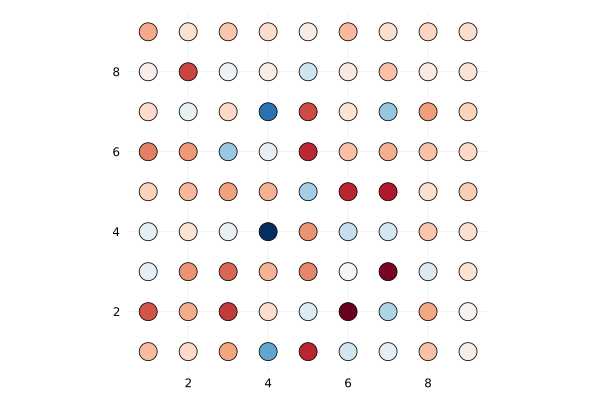

In [724]:
Iind = repeat(1:9,1,9)
Jind = repeat((1:9)',9,1);
scatter(reverse(Iind,dims=1),reverse(Jind,dims=1),ratio=1,markersize=10,marker_z=(x,y)->K̆[10-round(Int,y),round(Int,x)],markercolor=:RdBu,legend=false,xlim=(0.5,9.5),ylim=(0.5,9.5),showaxis=false)

The Kalman gain isn't diagonally dominant. Mixes U and V modes together. In particular, higher U modes affect most V modes.

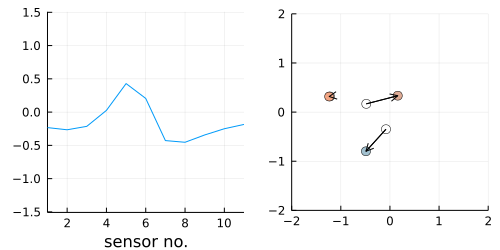

In [610]:
showmode(80,3,solhist,size=(500,250),xlim=(-2,2),ylim=(-2,2))

In [118]:
jdex = length(solhist)
vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_data;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = observations(mean(solhist[jdex].X),obs)
p_post_field = analytical_pressure(ζg,vort_post,config_data)
vort_post

2-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(0.004892547139997444 + 1.2422647790820311im, 1.3718576169384178, 0.01)
 Vortex.Blob(-1.299558228643725 + 0.2752890550604884im, 0.002796834207874021, 0.01)

In [1454]:
vortexmoment(1,zv_post,Γ_post)

0.1323842565617684 + 0.017687318398536378im

In [1455]:
vortexmoment(1,zv,Γv)

0.10311448912394362 - 0.023369634750555285im

In [1096]:
norm(solhist[end].X,solhist[end].Σx)

501.3953018717372

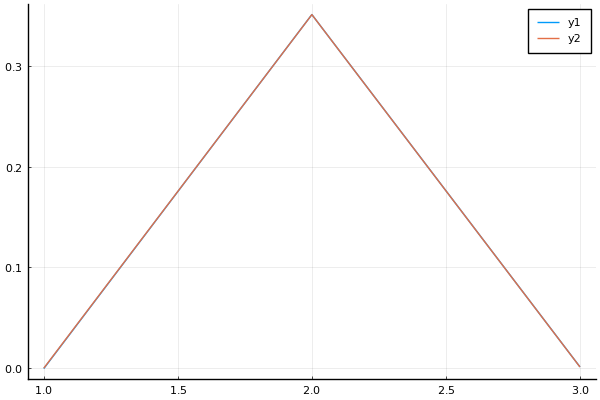

In [94]:
plot(y_post)
plot!(ystar)

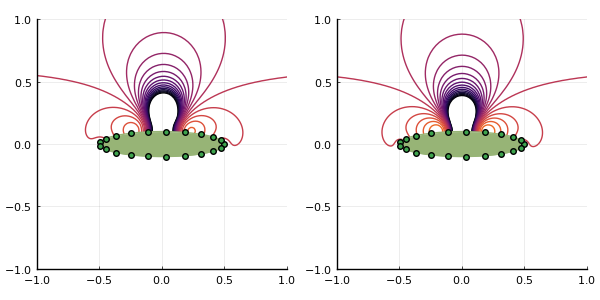

In [119]:
l = range(-1,1,length=31)
cl = (-1,1)
pl1 = contour(xg,yg,ptrue_field,ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
plot!(pl1,b)
scatter!(pl1,real.(sens_z),imag.(sens_z))
#plot!(x,y,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
pl2 = contour(xg,yg,p_post_field,ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
plot!(pl2,b)
scatter!(pl2,real.(sens_z),imag.(sens_z))
p1 = plot(pl1,pl2,size=(600,300))

In [1643]:
norm(ptrue_field-p_post_field)/norm(ptrue_field)

3.6547300835351115

### Explore the cost function topology
Here, we will map out the cost function's dependence on two components of the state, while
keeping the others fixed.

In [48]:
mean(solhist[jdex].X)

LoadError: BoundsError: attempt to access 36-element Vector{Any} at index [51]

In [198]:
Nv_explore = 1
config_data = VortexConfig(Nv_explore, δ,body=b)

# start with the final mean state
rmax = 1.8
rg = range(1.01,rmax,length=101)
θg = range(0,2π,length=101)

jdex = length(solhist)
xbase = mean(solhist[jdex].X)

costmap = zeros(length(θg),length(rg))
costmap_p = zeros(length(θg),length(rg))
costmap_m = zeros(length(θg),length(rg))


v_explore = 1
xbase[2Nv_explore + v_explore] = sum(x_true[2Nv_true+1:3Nv_true])

xij = copy(xbase)


for (j,rj) in enumerate(rg)
    xij[v_explore] = log(rj-1.0)
    for (i,θi) in enumerate(θg)
        xij[Nv_explore + v_explore] = θi*rj
        hx = observations(xij,analytical_force,sens,config_data)
        costmap[i,j] = norm(ystar-hx,solhist[jdex].Σy)
        xij[2Nv_explore+v_explore] = xbase[2Nv_explore+v_explore] + 0.2
        hx_p = observations(xij,analytical_force,sens,config_data)
        costmap_p[i,j] = norm(ystar-hx_p,solhist[jdex].Σy)
        xij[2Nv_explore+v_explore] = xbase[2Nv_explore+v_explore] - 0.2
        hx_m = observations(xij,analytical_force,sens,config_data)
        costmap_m[i,j] = norm(ystar-hx_m,solhist[jdex].Σy)
        xij[2Nv_explore+v_explore] = xbase[2Nv_explore+v_explore]
    end
end

In [202]:
maximum(costmap)

1000.3909730237684

In [199]:
ζg = rg'.*exp.(im*θg)
zg = conftransform(ζg,b);
xg = real(zg)
yg = imag(zg);

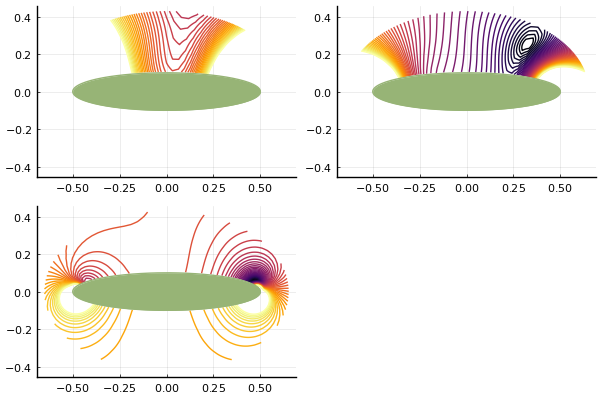

In [210]:
l = range(1.4,50,length=51)
cl=(1.4,50)
pl1 = contour(xg,yg,costmap_p,ratio=1,levels=l,clim=cl,legend=false)
plot!(pl1,b)
pl2 = contour(xg,yg,costmap,ratio=1,levels=l,clim=cl,legend=false)
plot!(pl2,b)
pl3 = contour(xg,yg,costmap_m,ratio=1,levels=l,clim=cl,legend=false)
plot!(pl3,b)
plot(pl1,pl2,pl3)

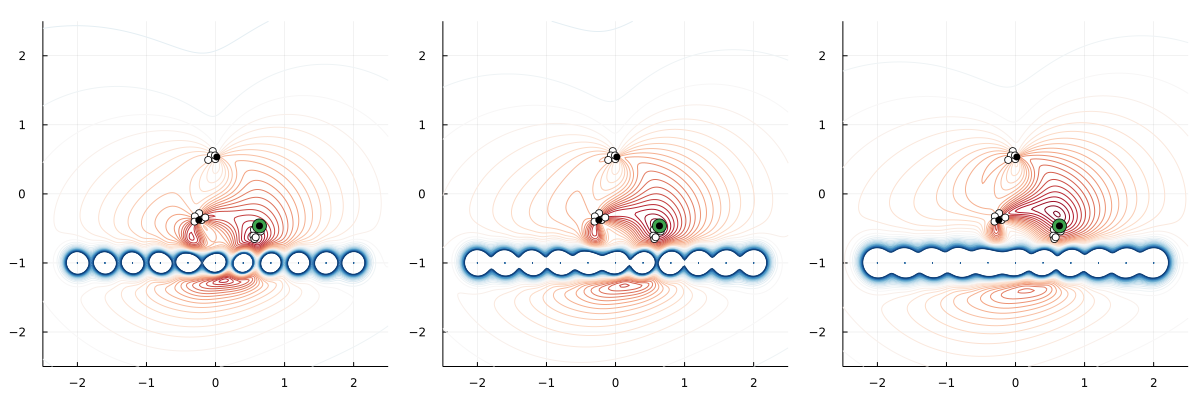

In [1592]:
truex = x_true[1:2:2Nv_true]
truey = x_true[2:2:2Nv_true]
currentx = xbase[1:2:2Nv]
currenty = xbase[2:2:2Nv]
minc = 0.3 #minimum([minimum(costmap_p),minimum(costmap),minimum(costmap_m)])
p1 = plot(xg,yg,costmap',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1,truex,truey,markercolor=:white,legend=false)
scatter!(p1,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_p = plot(xg,yg,costmap_p',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_p,truex,truey,markercolor=:white,legend=false)
scatter!(p1_p,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_p,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_m = plot(xg,yg,costmap_m',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_m,truex,truey,markercolor=:white,legend=false)
scatter!(p1_m,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_m,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

plot(p1_m,p1,p1_p,layout=(1,3),size=(1200,400))

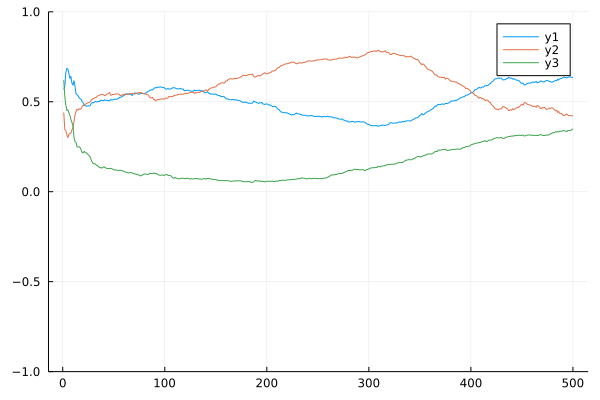

In [1571]:
plot(map(x -> mean(x.X)[2Nv+1],solhist),ylim=(-1,1))
plot!(map(x -> mean(x.X)[2Nv+2],solhist),ylim=(-1,1))
plot!(map(x -> mean(x.X)[2Nv+3],solhist),ylim=(-1,1))

In [555]:
#=
q = 10
A = zeros(q,q)
A[1,:] .= 1.0/q
for j in 2:q
    A[j,j-1] = -1.0
    A[j,j] = 1.0
end
A

i1, j1 = 3, 7
P = zeros(q,q)
for j in 1:q
    P[j,j] = 1.0
end
v = P[:,i1]
P[:,i1] .= P[:,j1]
P[:,j1] .= v
P;

dθ = Uniform(0,π)
dln = LogNormal(-2,1);;
[mean(dln) std(dln)]

dθ = Uniform(0,π)
dln = LogNormal(-2,1);
#dln = Chi(2);

q = 40
A = zeros(q,q)
A[1,:] .= 1.0/q
for j in 2:q
    A[j,j-1] = -1.0
    A[j,j] = 1.0
end
A

x̃, ỹ = zeros(q), zeros(q)
for j in 2:q
    zj = rand(dln)*exp(im*rand(dθ))
    x̃[j] = real(zj)
    ỹ[j] = imag(zj)
end

x = inv(A)*x̃;
y = inv(A)*ỹ;
scatter(x,y,ratio=1)
=#

In [302]:
dy̆ = hcat(map(x -> vcat(mean(x.Y̆),zeros(6-length(mean(x.Y̆)))),solhist)...);

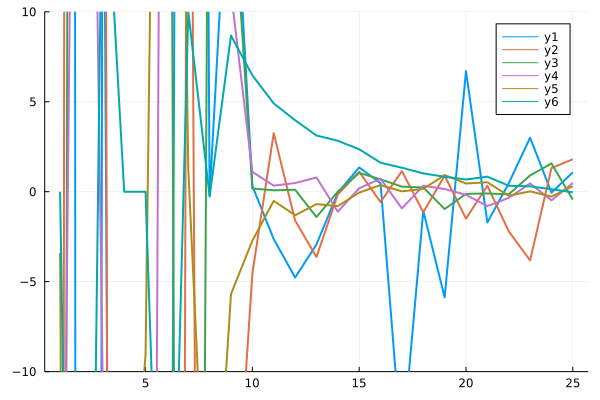

In [312]:
plot(dy̆[1,:],linewidth=2,ylim=(-10,10))
plot!(dy̆[2,:],linewidth=2)
plot!(dy̆[3,:],linewidth=2)
plot!(dy̆[4,:],linewidth=2)
plot!(dy̆[5,:],linewidth=2)
plot!(dy̆[6,:],linewidth=2)

In [290]:
dx̆ = hcat(map(x -> mean(x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)),solhist)...);

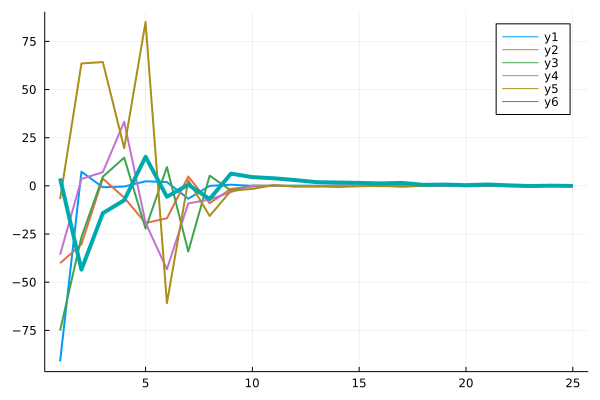

In [306]:
plot(dx̆[1,:],linewidth=2)
plot!(dx̆[2,:],linewidth=2)
plot!(dx̆[3,:],linewidth=2)
plot!(dx̆[4,:],linewidth=2)
plot!(dx̆[5,:],linewidth=2)
plot!(dx̆[6,:],linewidth=4)

In [79]:
sqrt(Σx)*Fhist[end].V[:,1:rhist[end]]*K̃*ỹhist[end]

9-element Vector{Float64}:
  0.0018490395330256174
 -0.005118568346242631
 -0.00357188260657286
 -0.00446458150403976
  0.008487842822575746
  0.007777494563758844
  0.0025521443428678826
  0.0045746465120252025
  0.0025497897622294495

36-element Vector{Float64}:
 1321.9159271767949
  197.92969822660362
   60.65322971203477
   14.070451613159014
    2.524231697075501
    0.08879175290868446
    0.0024909038486424285
    0.0003641957099004161
    8.743238899015276e-5
    1.1374831855011818e-5
    1.1561468627527092e-6
    6.920089409510231e-9
    2.6473141167366238e-9
    ⋮
    2.4868995751603507e-14
    2.259396132881637e-14
    1.4422580366206255e-14
    1.4210854715202004e-14
    1.0552812029956029e-14
    9.978272503795993e-15
    9.166656117039269e-15
    7.54697596667468e-15
    7.105427357601002e-15
    5.985093828153431e-15
    5.80939686960131e-15
    4.273885897591831e-15

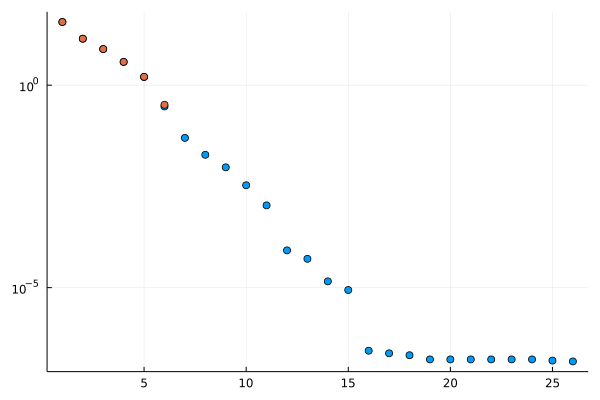

In [218]:
Λx = solhist[end].Λx[solhist[end].Λx.>100*eps()]
Λy = solhist[end].Λy[solhist[end].Λy.>100*eps()]
pl = scatter(sqrt.(Λy),yscale=:log10,legend=false)
scatter!(pl,sqrt.(Λx),yscale=:log10,legend=false)

#savefig("4vortex-svalues.pdf")
#savefig("4vortex-svalues.png")
display(pl)

In [98]:
LowRankVortex.P

9×9 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0459763   0.180721    -0.466078   -0.664597   …  -0.231686    0.0589482
  0.0788804   0.00428573   0.5093      0.0835935      0.144961    0.278253
  0.16449    -0.0732933   -0.140497    0.307257      -0.443203    0.0570702
  0.826368   -0.026383    -0.299224    0.252782      -0.0776115  -0.0232306
 -0.231958    0.659137    -0.13104     0.492813       0.098887    0.0212657
 -0.0686195   0.535204    -0.0629612   0.0229107  …  -0.31879    -0.054013
 -0.0602487  -0.0762433   -0.49928     0.106125       0.689798   -0.213156
 -0.280826   -0.279705    -0.361859    0.22372       -0.0813069   0.771225
 -0.375122   -0.395349    -0.112926    0.297177      -0.359191   -0.521258

In [99]:
V[1:2,1] + V[4:5,1] + V[7:8,1]

2-element Vector{Float64}:
  0.7201431166604436
 -0.43390344986838764

In [961]:
unitvec = zeros(length(x_post))
unitvec[6] = 1.0
F.Vt*unitvec

6-element Vector{Float64}:
  0.574771771360253
  0.22247709382174288
 -0.3319587477794311
  0.11918085260192823
 -0.24380484125187668
  0.6605299895538166

In [1318]:
F.V[:,1]

9-element Vector{Float64}:
 -0.0013365146346376764
 -0.3437027395751458
  0.0829705149437211
 -0.3194680056247702
 -0.08144756026540528
 -0.32315728742537086
  0.259381193123849
  0.5453208346181756
  0.5451650888170947

In [1319]:
cumsum(F.S)/sum(F.S)

9-element Vector{Float64}:
 0.5459333120939325
 0.7545316235684618
 0.8396933430067108
 0.9155493243748806
 0.9677749179838403
 0.9879966879557416
 0.9990439288567136
 0.9997043000270978
 0.9999999999999999